# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

In [2]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/Users/rb2/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /Users/rb2/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /Users/rb2/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

In [3]:
from collections import Counter

tokenizer = get_tokenizer("basic_english")
def build_vocabulary(dataset: np.ndarray, tokenizer: Callable) -> Vocab:
    tokens = tokenizer(" ".join(dataset["text"]))
    counter = Counter(tokens)
    return vocab(counter, min_freq=10, specials=["<unk>", "<pad>"])

vocabulary = build_vocabulary(train_df, tokenizer)

# set index for unknown and padding tokens
vocabulary.set_default_index(vocabulary["<unk>"])

In [4]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor(
        [vocabulary[token] for token in tokenizer(text)], dtype=torch.long
    )


In [5]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

In [6]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([  39, 4850,   11,  265,  646,    8,   27,   27,   27,    0])

In [7]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    for i in range(0, len(X), batch_size):
        X_batch = nn.utils.rnn.pad_sequence(
            X[i : i + batch_size], padding_value=pad_id, batch_first=True
        )
        y_batch = torch.tensor(y[i : i + batch_size], dtype=torch.long)
        yield X_batch, y_batch

In [9]:
pad_token = "<pad>"
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [11]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [25]:
import torch.optim as optimizer
from copy import deepcopy

def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """
    # We are using a function, as we will use it on several models here.
    # The RNN implementation of pyTorch doesn't need to be manually looped. 
    # As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.
    # use `out, _ = self.rnn(out, h0)` to get the last value of the output layer.
    # The training loop.
    # Target size must be the same as input size (torch.Size([32, 1]))

    # The training loop.
    best_model = deepcopy(model)
    train_losses, valid_losses = [], []
    for epoch in range(n_epochs):
    # Training
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_gen():
            X_batch = X_batch.to(device)
            y_batch = y_batch.float().to(device).unsqueeze(1) # Updated line
            # Forward pass
            y_pred = model(X_batch)
            # Loss computation
            loss = criterion(y_pred, y_batch)
            # Backpropagation
            loss.backward()
            # Parameter update
            optimizer.step()
            # Reset the gradients
            optimizer.zero_grad()
            batch_losses.append(loss.item())
        train_losses.append(np.mean(batch_losses))
        # Validation
        model.eval()
        batch_losses = []
        for X_batch, y_batch in valid_gen():
            X_batch = X_batch.to(device)
            y_batch = y_batch.float().to(device).unsqueeze(1) # Updated line
            # Forward pass and loss computation
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            batch_losses.append(loss.item())
        valid_losses.append(np.mean(batch_losses))
        # Keep the best model
        if valid_losses[-1] == min(valid_losses):
            best_model = deepcopy(model)
        print(
            f"Epoch {epoch+1}/{n_epochs}, train loss: {train_losses[-1]:.4f}, valid loss: {valid_losses[-1]:.4f}"
        )
    return best_model, train_losses, valid_losses

In [26]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [27]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

Epoch 1/20, train loss: 0.6953, valid loss: 0.6954
Epoch 2/20, train loss: 0.6937, valid loss: 0.6967
Epoch 3/20, train loss: 0.6934, valid loss: 0.6947
Epoch 4/20, train loss: 0.6946, valid loss: 0.6977
Epoch 5/20, train loss: 0.6946, valid loss: 0.6965
Epoch 6/20, train loss: 0.6949, valid loss: 0.6943
Epoch 7/20, train loss: 0.6948, valid loss: 0.6935
Epoch 8/20, train loss: 0.6951, valid loss: 0.6954
Epoch 9/20, train loss: 0.6943, valid loss: 0.6971
Epoch 10/20, train loss: 0.6945, valid loss: 0.6958
Epoch 11/20, train loss: 0.6950, valid loss: 0.6940
Epoch 12/20, train loss: 0.6943, valid loss: 0.6933
Epoch 13/20, train loss: 0.6949, valid loss: 0.6942
Epoch 14/20, train loss: 0.6942, valid loss: 0.6940
Epoch 15/20, train loss: 0.6941, valid loss: 0.6937
Epoch 16/20, train loss: 0.6948, valid loss: 0.6934
Epoch 17/20, train loss: 0.6941, valid loss: 0.6966
Epoch 18/20, train loss: 0.6947, valid loss: 0.6944
Epoch 19/20, train loss: 0.6945, valid loss: 0.6944
Epoch 20/20, train lo

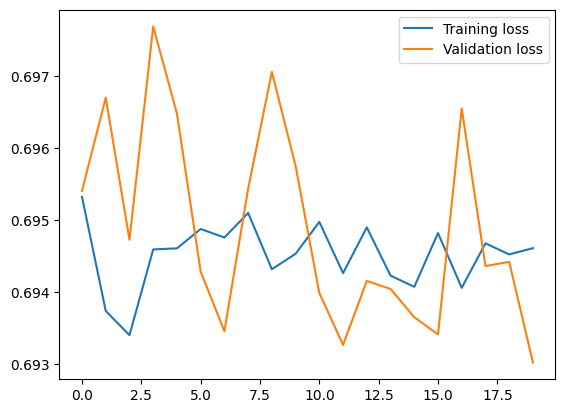

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

In [29]:
# Add an accuracy function 
def accuracy(model: nn.Module, gen: Callable) -> float:
    """Compute the accuracy of a model.
    Args:
        model: a class inheriting from nn.Module.
        gen: a callable function returing a batch (data, labels).
    Returns:
        The accuracy of the model.
    """
    model.eval()
    correct = 0
    total = 0
    for X_batch, y_batch in gen():
        X_batch = X_batch.to(device)
        y_batch = y_batch.float().to(device).unsqueeze(1) # Updated line
        y_pred = model(X_batch)
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        correct += (y_pred == y_batch).sum().item()
        total += y_batch.size(0)
    return correct / total

# Compute the accuracy of the training set.
accuracy(best_model, train_gen)

# Compute the accuracy of the validation set.
accuracy(best_model, valid_gen)

# Compute the accuracy of the test set.
accuracy(best_model, test_gen)

0.50464

In [30]:
# Create a LSTM class with Pytorch which uses LSTM instead of RNN.
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_size: int,
        n_layers: int,
        n_outputs: int,
    ):
        """Initialize a LSTM.
        Args:
            vocab_size: the size of the vocabulary.
            embedding_dim: the dimension of the embedding.
            hidden_size: the size of the hidden layer.
            n_layers: the number of layers.
            n_outputs: the number of outputs.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, (h0, c0))
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

In [36]:
# Train the LSTM model.

model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

# Plot the losses.
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

# Compute the accuracy of the training set.
print(accuracy(best_model, train_gen))

# Compute the accuracy of the validation set.
print(accuracy(best_model, valid_gen))

# Compute the accuracy of the test set.
print(accuracy(best_model, test_gen))


Epoch 1/20, train loss: 0.6935, valid loss: 0.6929
Epoch 2/20, train loss: 0.6931, valid loss: 0.6929
Epoch 3/20, train loss: 0.6929, valid loss: 0.6931
Epoch 4/20, train loss: 0.6919, valid loss: 0.6932


KeyboardInterrupt: 

In [35]:
# Implement a function which takes any text and returns the model's prediction.
    #The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).

(1, 1.0)